# machina example

Please follow install instruction in README.md for preparation to download kNN index and data.

In this example, the query is SCOP domain `d1qg3a1` and the template is `d1va9a1`.

Their PSSMs are already in this repository.

**Note**

Optionally, you can download example PSSMs of query and template protein domains.

```bash
mkdir data/pssm data/pssm/qg data/pssm/va
wget -O data/pssm/qg/d1qg3a1.mtx http://www.cb.cs.titech.ac.jp/~makigaki/machina/data/pssm/qg/d1qg3a1.mtx
wget -O data/pssm/va/d1va9a1.mtx http://www.cb.cs.titech.ac.jp/~makigaki/machina/data/pssm/va/d1va9a1.mtx
```

These PSSMs were generated by three-iteration PSI-BLAST searching into Uniref90.

```bash
psiblast -query <query_fasta> \
         -db <uniref90_dir> \
         -num_iterations 3 \
         -out_ascii_pssm data/pssm/{query_id[2:3]}/<query_id>.mtx \
         -save_pssm_after_last_round
```

Please note that machina requires ASCII formatted PSSM and the out directory is not frexible.

## Predict substitution score

This consumes 23GB RAM.

In [7]:
from machina.predict import predict_scores

query = 'd1qg3a1'
template = 'd1va9a1'
predict_scores(query, template)

100%|██████████| 1/1 [00:00<00:00, 1408.90it/s]


## Generate pairwise alignments

In [8]:
from pathlib import Path

from machina.generate_alignment import generate_alignment

GAP_OPEN = -0.1
GAP_EXTEND = -0.01

result_dir = Path('results')/f'{knn_index_name}_nn{nn}'
result_dir.mkdir(exist_ok=True, parents=True)
result_file = result_dir/Path(f'{query}_open{-GAP_OPEN}_extend{-GAP_EXTEND}.npy')
result = generate_alignment(
    Path(f'data/prediction/{knn_index_name}_nn{nn}/{query}/{template}.npy'),
    GAP_OPEN, GAP_EXTEND)
np.save(result_file, np.array([result]))

## Make models

Install MODELLER to make models and download template PDB.

```bash
mkdir data/scop_e/va
wget -O data/scop_e/va/d1va9a1.ent http://www.cb.cs.titech.ac.jp/~makigaki/machina/data/scop_e/va/d1va9a1.ent
```

In [30]:
from machina.generate_models import MachinaModel


aligns_list = np.load(result_file)
MachinaModel().generate_protein_model(query, template, aligns_list, result_dir.as_posix())

## Visualize

-------DLGAPQNPNAKAAGSRKIHFNWLPPS-----GKPMGYRVKYWIQGDSES-EAHLLDS----KVPSVELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ
ISTEEAAPDGPPMDVTLQPVTSQSIQVTWKAPKKELQNGVIRGYQIGYRENSPGSNGQYSIVEMKATGDSEVYTLDNLKKFAQYGVVVQAFNRAGTGPSSSEINATTLE


[None, None]

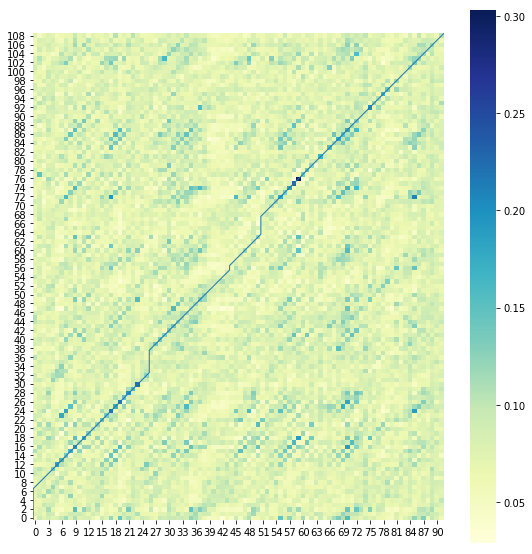

In [17]:
%matplotlib inline

from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from matplotlib import pyplot
import seaborn as sns
from IPython.display import display

def alignment_graph(alignment):
    assert len(alignment[0]) == len(alignment[1])
    x, y = [0], [0]
    for i in range(len(alignment[0])):
        if alignment[0][i] == '-':
            x.append(x[-1])
            y.append(y[-1] + 1)
        elif alignment[1][i] == '-':
            x.append(x[-1] + 1)
            y.append(y[-1])
        else:
            x.append(x[-1] + 1)
            y.append(y[-1] + 1)
    return np.array(x), np.array(y)

labels = np.load(f'data/prediction/{knn_index_name}_nn{nn}/{query}/{template}.npy')
index = list(SeqIO.parse(f'{result_dir.as_posix()}/{template}.pir', 'pir'))
x, y = alignment_graph(MultipleSeqAlignment(index))

fig, ax = pyplot.subplots(figsize=(labels.shape[0]/10, labels.shape[1]/10))
sns.heatmap(labels.T, ax=ax, linewidths=0, square=True, rasterized=True, cmap="YlGnBu", cbar_kws={"shrink": 0.9}).invert_yaxis()
ax.plot(x, y, linewidth=1)
display([print(_.seq) for _ in index])

In [18]:
import nglview

nglview.show_file(f'results/flann19_scop40_logscore_tmscore50_w5_randomsampling_ratio0.1_nn1000/d1va9a1.pdb')

NGLWidget()